In [1]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # add relative path

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

### Define STTR model

In [2]:
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=8
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [3]:
model = STTR(args).cuda().eval()

In [4]:
# Load the pretrained model
model_file_name = "../kitti_finetuned_model.pth.tar"
checkpoint = torch.load(model_file_name)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


### Read image

In [5]:
left = np.array(Image.open('../sample_data/KITTI_2015/training/image_2/000046_10.png'))
right = np.array(Image.open('../sample_data/KITTI_2015/training/image_3/000046_10.png'))
disp = np.array(Image.open('../sample_data/KITTI_2015/training/disp_occ_0/000046_10.png')).astype(np.float) / 256.

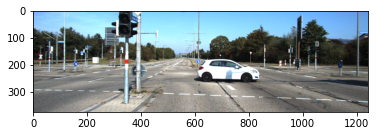

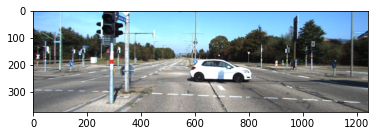

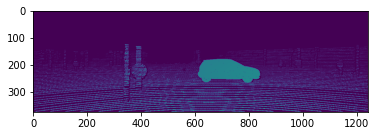

In [6]:
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)
plt.figure(3)
plt.imshow(disp)

Preprocess data for STTR

In [7]:
# normalize
input_data = {'left': left, 'right':right, 'disp':disp}
input_data = normalization(**input_data)

In [8]:
# donwsample attention by stride of 3
h, w, _ = left.shape
bs = 1

downsample = 3
col_offset = int(downsample / 2)
row_offset = int(downsample / 2)
sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1).cuda()
sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1).cuda()

In [9]:
# build NestedTensor
input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

### Inference

In [10]:
output = model(input_data)

In [11]:
# set disparity of occ area to 0
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0

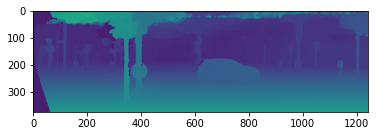

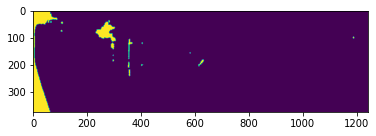

In [12]:
# visualize predicted disparity and occlusion map
plt.figure(4)
plt.imshow(disp_pred)
plt.figure(5)
plt.imshow(occ_pred)

### Compute metrics

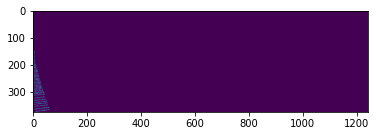

In [13]:
# manually compute occluded region
occ_mask = compute_left_occ_region(w, disp)

# visualize the known occluded region
plt.figure(6)
plt.imshow(occ_mask)

In [14]:
# compute difference in non-occluded region only
diff = disp - disp_pred
diff[occ_mask] = 0.0 # set occ area to be 0.0

# Note: code for computing the metrics can be found in module/loss.py
valid_mask = np.logical_and(disp > 0.0, ~occ_mask)

# find 3 px error
err_px = (diff > 3).sum()
total_px = (valid_mask).sum()
print('3 px error %.3f%%'%(err_px*100.0/total_px))

# find epe
err = np.abs(diff[valid_mask]).sum()
print('EPE %f'%(err * 1.0/ total_px))

3 px error 0.204%
EPE 0.275364
